In [2]:
# General 
import sys
import math
import time
import numpy as np
import pandas as pd
#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
#GPyTorch
import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import tqdm
#Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Load the data

In [3]:
class ExperimentData:
    def __init__(self,filepath,name):
        self.filepath = filepath 
        self.name = name
        self.read_data(filepath)
        # Initialize GP hyperparameters
        self.length_scale = [1, 1]
        self.sigma_f = 0.5
        self.sigma_n = 0.1
        self.kernel_dict = {}
        self.prediction_dict = {}
        
    def read_data(self, array_type="None"):
        training_data = pd.read_csv(self.filepath)
        training_data_array = training_data.to_numpy()
        # Return torch array type needed for training with GPyTorch
        if array_type == 'torch':
            self.X = torch.FloatTensor(np.stack((training_data_array[:, 0], training_data_array[:, 1]), axis=-1))
            self.y = torch.FloatTensor(training_data_array[:, 2:4])
        # Otherwise just load numpy array
        else:
            self.X = np.stack((training_data_array[:, 0], training_data_array[:, 1]), axis=-1)
            self.y = training_data_array[:, 2:4]
        # Test_train_split
        self.test_train_split()
        
    def test_train_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=1)
    
    def save_kernel_params(self, name, length_scale, sigma_f, variance, sigma_n):
        self.kernel_dict[name] =  [length_scale[0], length_scale[1], sigma_f, variance, sigma_n]
        
    def save_prediction(self, name, mean, upper, lower):
        self.prediction_dict[name] = [mean, upper, lower]
    
    # Plotting functions
    def plot_input_data(self):
        fig, axs = plt.subplots(2, 3)
        fig.set_size_inches(18.5, 10.5)
        axs[0, 0].remove()
        ax1 = fig.add_subplot(2, 3, 1, projection='3d')
        ax1.scatter(self.X[:, 0], self.X[:, 1], self.y[:,0])
        axs[0, 1].plot(self.X[:,0], self.y[:,0], 'r*')
        axs[0, 1].set_xlabel("x-direction[m]")
        axs[0, 1].set_ylabel("force in x-direction [m/s^2]")
        axs[0, 2].plot(self.X[:,1], self.y[:,0], 'g*')
        axs[0, 2].set_xlabel("y-direction[m]")
        axs[0, 2].set_ylabel("force in x-direction [m/s^2]")
        axs[1, 0].remove()
        ax4 = fig.add_subplot(2, 3, 4, projection='3d')
        ax4.scatter(self.X[:, 0], self.X[:, 1], self.y[:,1])
        axs[1, 1].plot(self.X[:, 0], self.y[:,1], 'r*')
        axs[1, 1].set_xlabel("x-direction[m]")
        axs[1, 1].set_ylabel("force in y-direction [m/s^2]")
        axs[1, 2].plot(self.X[:, 1], self.y[:,1], 'g*')
        axs[1, 2].set_xlabel("y-direction[m]")
        axs[1, 2].set_ylabel("force in y-direction [m/s^2]")
        fig.suptitle(self.name)
        plt.show()
        
    def plot_wind_field(self, X=None, y=None, res=8, title=None, name=None):
        fig, ax = plt.subplots(1, 1)
        plt.axis('equal')
        plt.grid(linestyle=':')
        if X is None:
            X = self.X
            y = self.y
            title = self.name
        q = plt.quiver(X[::res, 0], X[::res, 1], y[::res,0], y[::res,1], scale=2.54, color='r',
                       units='width', scale_units="inches", width=0.003)
        plt.title(title, fontsize=16)
        plt.xlabel('x in m', fontsize=12)
        plt.ylabel('y in m', fontsize=12)
        plt.rc('xtick', labelsize=12) 
        plt.rc('ytick', labelsize=12) 
        plt.ioff()
        plt.autoscale()
        if not name==None:
            plt.savefig(name,  bbox_inches="tight")
        plt.show()

In [4]:
experiment_data_dict = \
    {"Lemniscate with two random fans": 
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_xy_random_2022-09-07-10-52-31.csv",
     "Lemniscate with one fan in x direction": 
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_x_dir_2022-09-07-10-45-44.csv",
     "Lemniscate with one fan in y direction":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_y_dir_2022-09-14-15-02-36.csv",
     "Lemniscate with four random fans":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_4_fans_2022-09-14-15-09-36.csv",
     "Random trajectory with four random fans":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_4_fans_random_path1_2022-09-14-15-46-56.csv",
     "Lemniscate with two fans in x-y direction":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_xy_dir_2022-09-07-10-48-53.csv",
     "Line path combined":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_xy_random_line_path_combined.csv",
     "Structured path":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_y_dir_structured_path_2022-09-17-16-31-10.csv",
     "Structured path":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_2_fans_random_structured_path_2022-09-17-16-52-26.csv",
     "Structured path tsp":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_2_fans_random_tsp_path_2022-09-21-12-11-10.csv",
     "TSP path with custom controller":
         "/home/johanna/MasterThesis/Wind_data/sim_data/simplecontrol_windsimplesim_2_fans_random_tsp_path_2022-09-25-13-14-59.csv",
     "TSP path with custom controller 2":
         "/home/johanna/MasterThesis/Wind_data/sim_data/simplecontrol_windsimplesim_2_fans_random_tsp_path_combined.csv",
     "Structured path custom controller":
         "/home/johanna/MasterThesis/Wind_data/sim_data/simplecontrol_windsimplesim_2_fans_random_structured_path_2022-09-25-17-01-49.csv",
     "Active learning path":
         "/home/johanna/MasterThesis/Wind_data/sim_data/simplecontrol_windsimplesim_2_fans_random_tsp_path_2022-09-29-12-14-38.csv"
    }

<IPython.core.display.Javascript object>


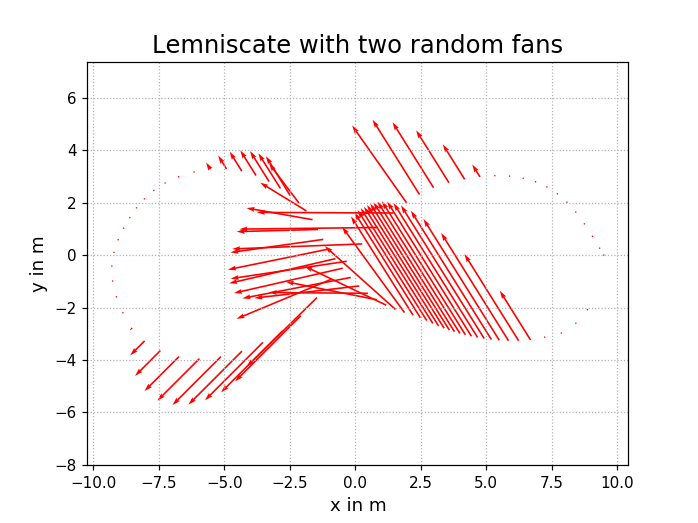

<IPython.core.display.Javascript object>


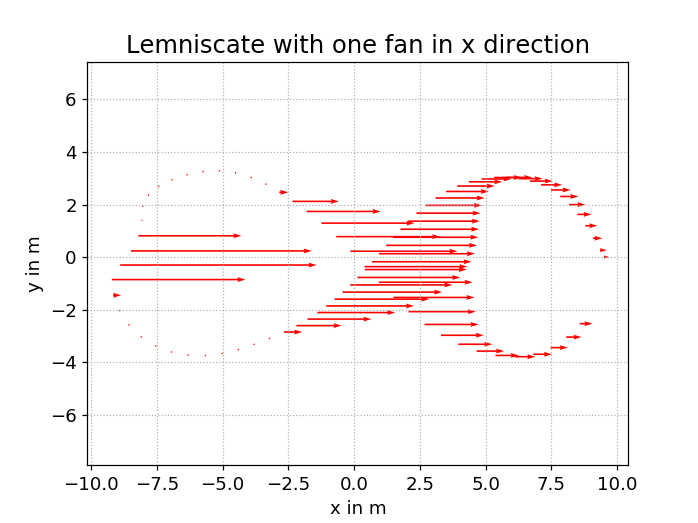

<IPython.core.display.Javascript object>


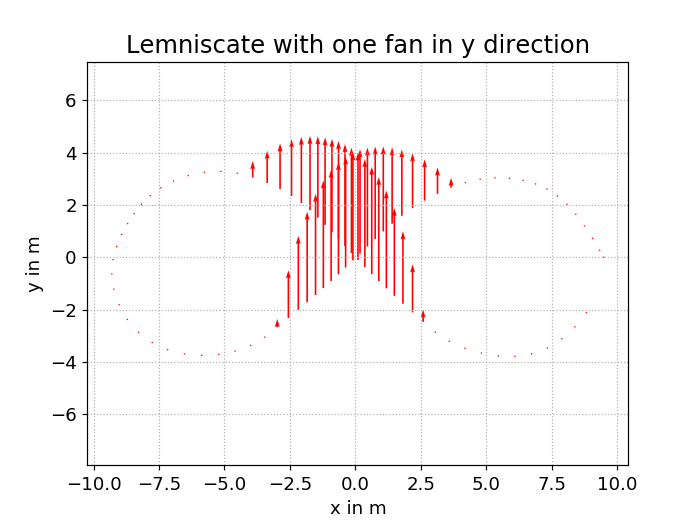

<IPython.core.display.Javascript object>


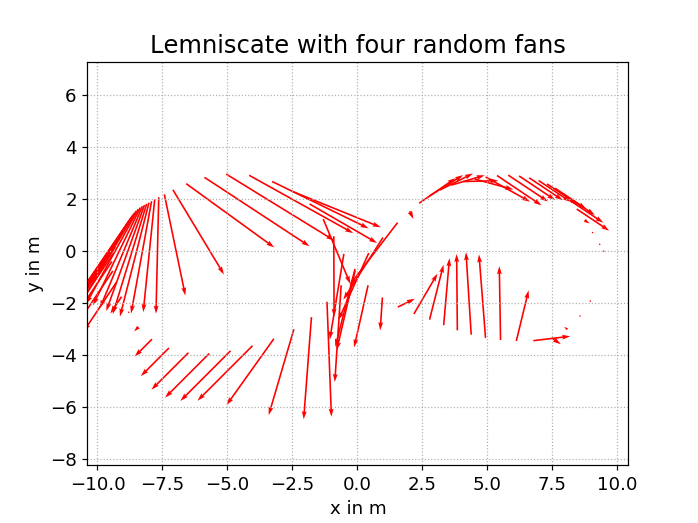

<IPython.core.display.Javascript object>


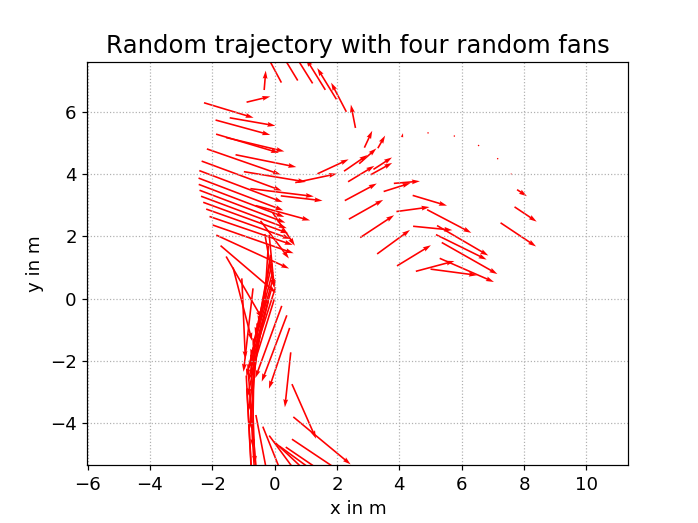

<IPython.core.display.Javascript object>


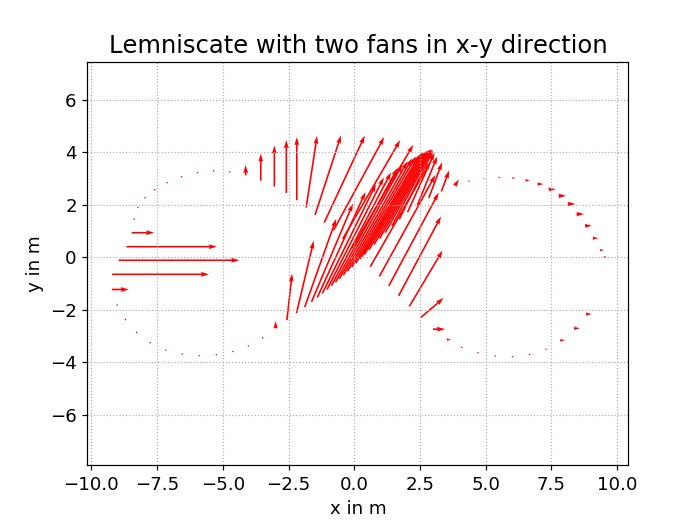

<IPython.core.display.Javascript object>


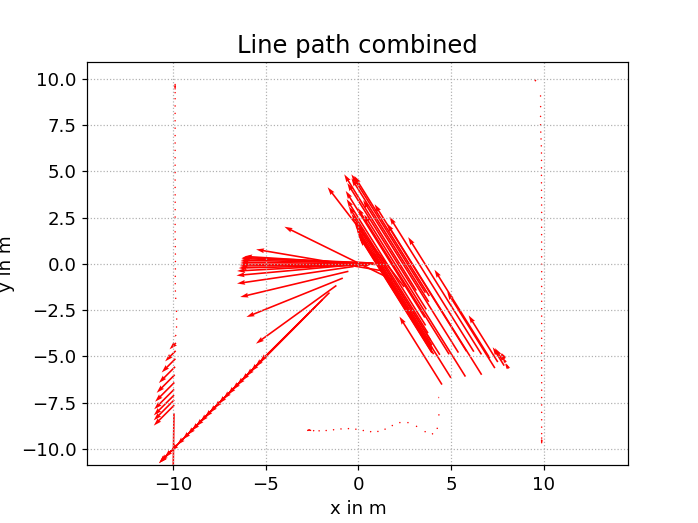

<IPython.core.display.Javascript object>


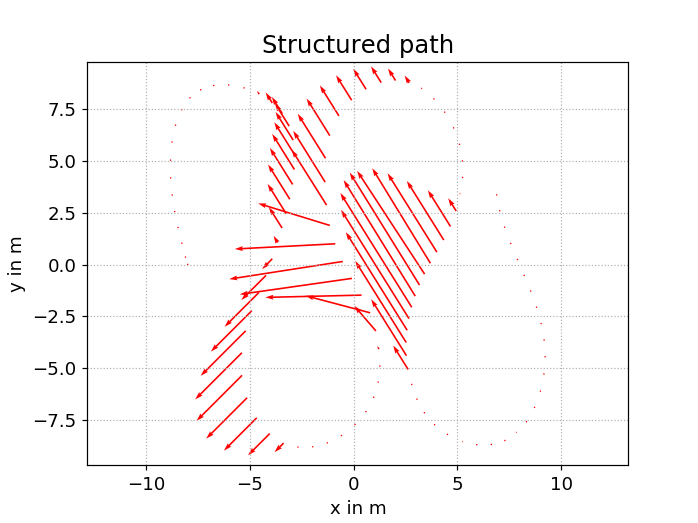

<IPython.core.display.Javascript object>


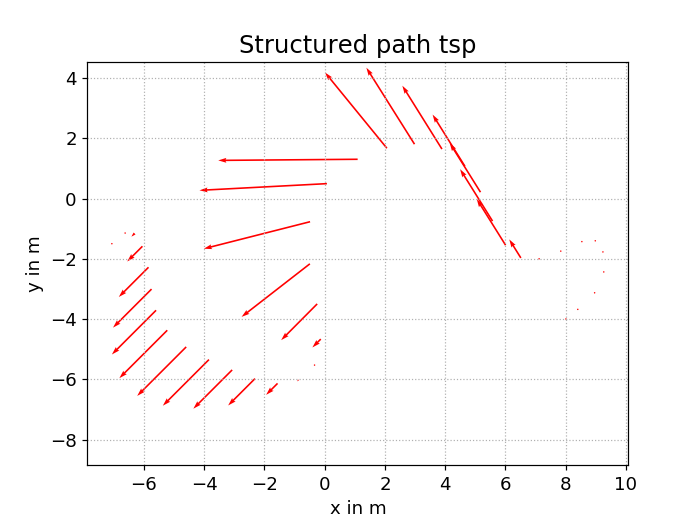

<IPython.core.display.Javascript object>


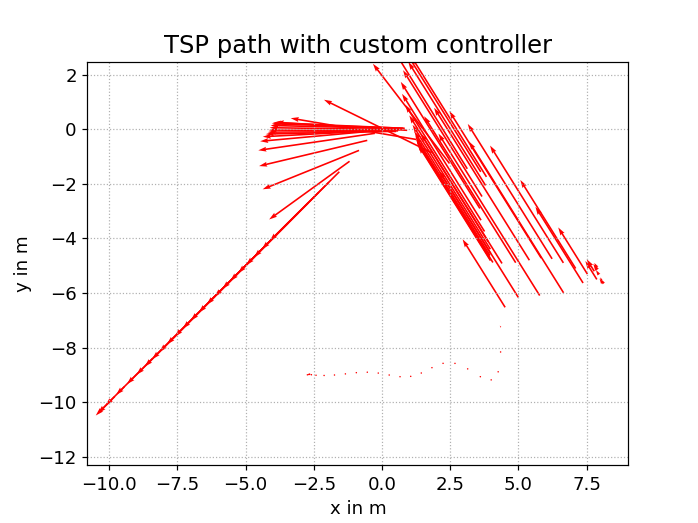

<IPython.core.display.Javascript object>


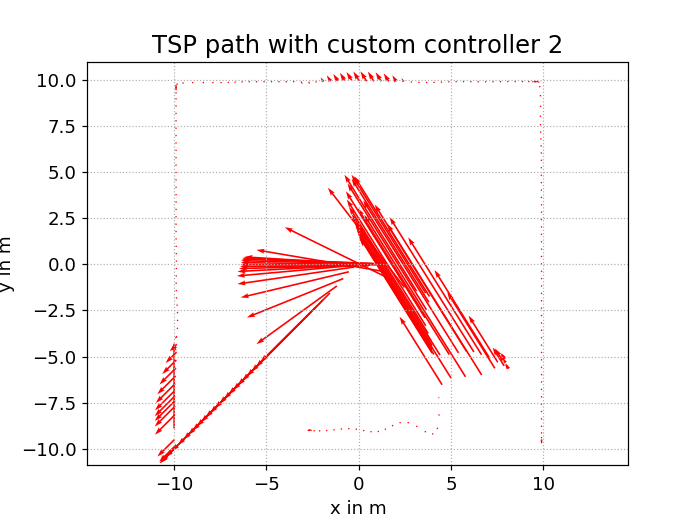

<IPython.core.display.Javascript object>


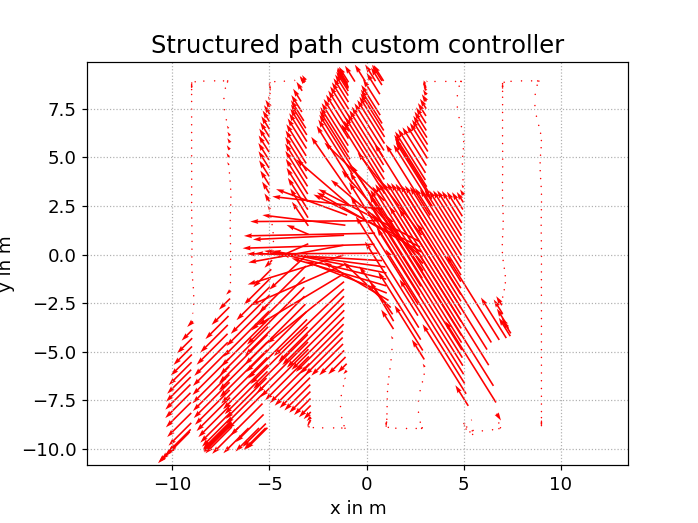

<IPython.core.display.Javascript object>


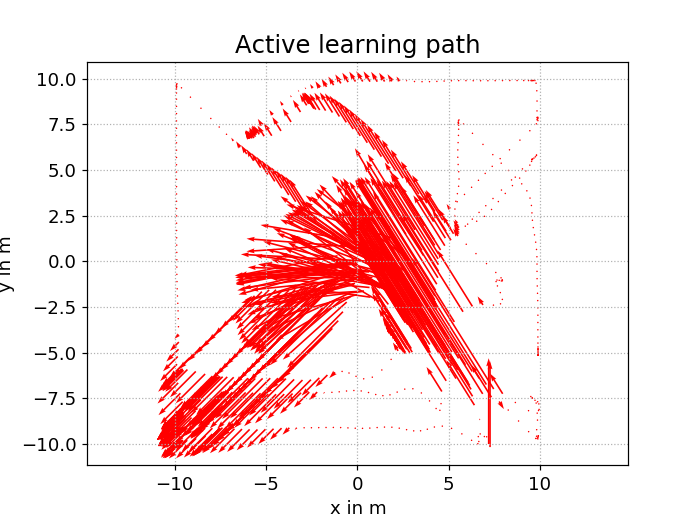

In [5]:
experiment_data = []
for experiment in experiment_data_dict:
    data = ExperimentData(experiment_data_dict[experiment], experiment)
    experiment_data.append(data)
for i in range(len(experiment_data)):
    # experiment_data[i].plot_input_data()
    experiment_data[i].plot_wind_field()

In [6]:
data = experiment_data[-1]

## Plot the inducing points

<IPython.core.display.Javascript object>


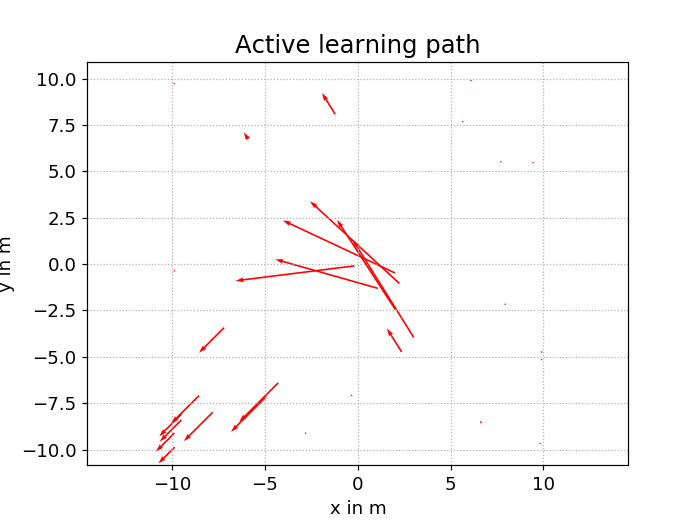

In [7]:
p_ind = 30
data.plot_wind_field(res=int(data.X.shape[0]/30))

# Sparse GPs with GPyTorch

In [8]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [9]:
class SparseGPyTorchRegression:
    def __init__(self, data, batch_size, epochs):
        # Change dataset to torch tensor
        self.data = data
        data.read_data("torch")
        self.likelihood = []
        self.model = []
        self.batch_size = batch_size
        self.n_epochs = epochs
    def fit(self):
        for i in range(self.data.y.shape[1]):
            train_dataset = TensorDataset(self.data.X_train, self.data.y_train[:,i])
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            print(self.data.y.shape[0])
            inducing_points = self.data.X_train[::int(self.data.y.shape[0]/30), :]
            model = GPModel(inducing_points=inducing_points)
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            model.train()
            likelihood.train()
            # Use the adam optimizer
            optimizer = torch.optim.Adam([
                {'params': model.parameters()},
                {'params': likelihood.parameters()},
            ], lr=0.01)
            # "Loss" for GPs - the marginal log likelihood
            mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=self.data.y_train[:,i].size(0))
            num_epochs = self.n_epochs
            epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
            for i in epochs_iter:
                # Within each iteration, we will go over each minibatch of data
                minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
                for x_batch, y_batch in minibatch_iter:
                    optimizer.zero_grad()
                    output = model(x_batch)
                    loss = -mll(output, y_batch)
                    minibatch_iter.set_postfix(loss=loss.item())
                    loss.backward()
                    optimizer.step()
            self.likelihood.append(likelihood)
            self.model.append(model)
        #self.save_kernel_params()
        
    def get_kernel_params(self):
        self.sigma_f = []
        self.length_scale = []
        self.variance = []
        self.sigma_n = []
        for i in range(self.data.y.shape[1]):
            self.sigma_f.append(self.model[i].covar_module.outputscale.item())
            self.length_scale.append([self.model[i].covar_module.base_kernel.kernels[0].lengthscale.detach().numpy().item(0),
                                      self.model[i].covar_module.base_kernel.kernels[0].lengthscale.detach().numpy().item(1)])
            self.variance.append(self.model[i].covar_module.base_kernel.kernels[1].variance.item())
            self.sigma_n.append(self.likelihood[i].noise_covar.noise.item())
    def save_kernel_params(self):
        self.get_kernel_params()
        for i in range(self.data.y.shape[1]):
            name = "gpytorch_y" + str(i+1) + "_" + str(self.batch_size) + "_" + str(self.n_epochs)
            self.data.save_kernel_params(name, self.length_scale[i], self.sigma_f[i], self.variance[i], self.sigma_n[i])
    def predict(self, X_test=data.X_test):
        self.mean = np.empty(X_test.shape)
        self.upper = np.empty(X_test.shape)
        self.lower = np.empty(X_test.shape)
        for i in range(self.data.y.shape[1]):
            self.model[i].eval()
            self.likelihood[i].eval()
            observed_pred = (self.model[i](X_test))
            self.mean[:,i] = observed_pred.mean.detach().numpy()
            lower, upper = observed_pred.confidence_region()
            self.upper[:,i] = lower.detach().numpy()
            self.lower[:,i] = upper.detach().numpy()
        #name = "gpytorch" + "_" + str(self.batch_size) + "_" + str(self.n_epochs)
        #self.data.save_prediction(name, self.mean, self.upper, self.lower)
    def save_model(self):
        for i in range(self.data.y.shape[1]):
            print(self.model[i].state_dict())
            name = "gpytorch_y" + str(i+1) + "_model.pth"
            torch.save(self.model[i].state_dict(), name)

In [10]:
data.read_data("torch")
sparse_gp_torch = SparseGPyTorchRegression(data, 30, 10)
# sparse_gp_torch.fit()
# sparse_gp_torch.predict(X_grid_torch)

In [11]:
def create_grid(start, stop, res, array_type = None):
    x = np.linspace(start, stop, res)
    y = np.linspace(start, stop, res)
    x, y = np.meshgrid(x, y)
    if array_type is None:
        X = np.stack((x.flatten(), y.flatten()), axis=-1)
    else:
        X = torch.FloatTensor(np.stack((x.flatten(), y.flatten()), axis=-1))
    return X, x, y
X_grid, x_grid, y_grid = create_grid(-9.9,9.9,51)
X_grid_torch, x_grid_torch, y_grid_torch = create_grid(-9.9,9.9,51, "torch")

# Plot the data from active learning to check that it is correct

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent

<IPython.core.display.Javascript object>


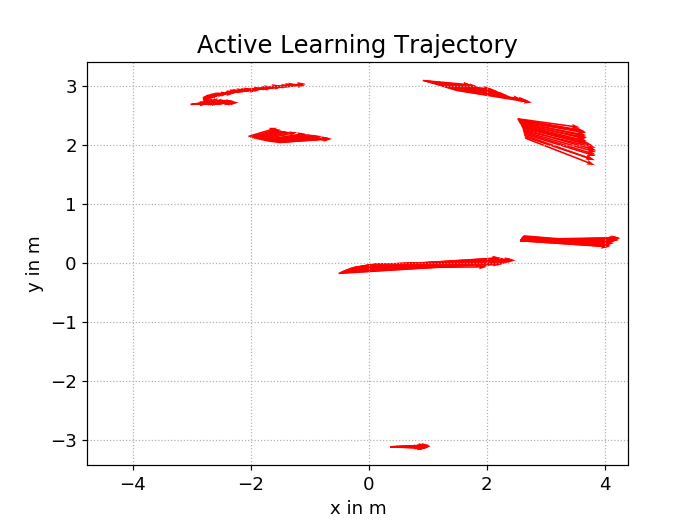

<IPython.core.display.Javascript object>


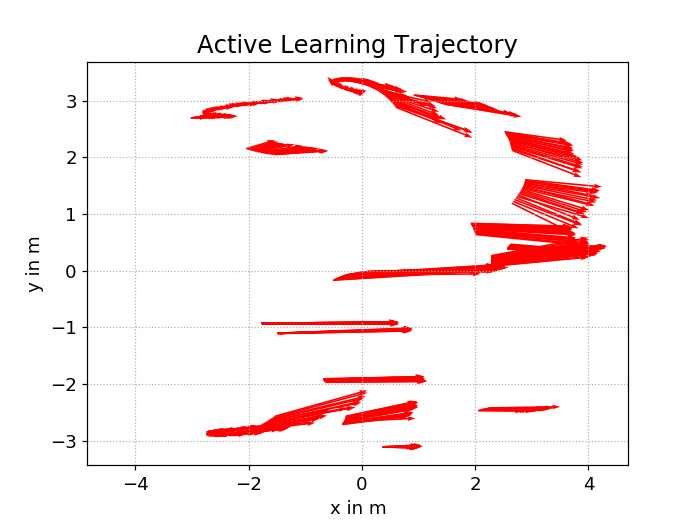

<IPython.core.display.Javascript object>


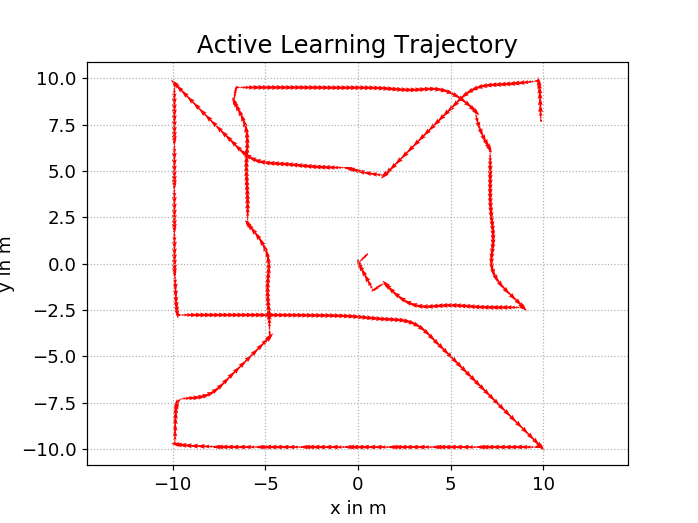

<IPython.core.display.Javascript object>


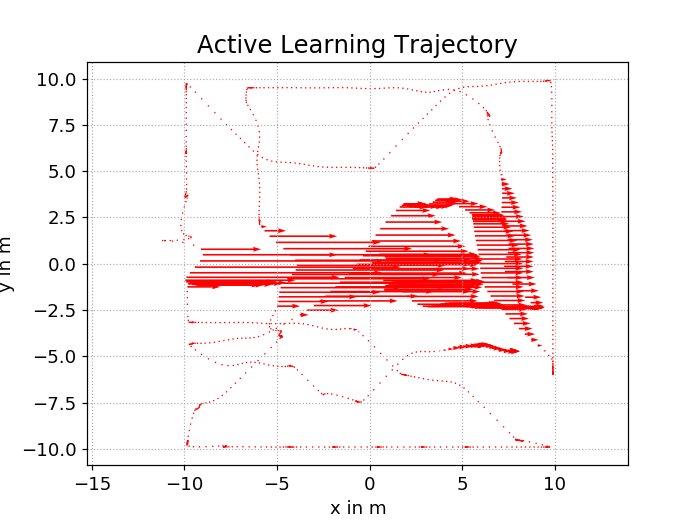

In [19]:
%matplotlib notebook
data1 = np.load('/home/johanna/MasterThesis/data/wind_data_1.npz')
X1 = data1['X'][:,:]
y1 = data1['y'][:,:]
experiment_data[1].plot_wind_field(X=X1, y=y1, res=1, title="Active Learning Trajectory", name="data1")
data2 = np.load('/home/johanna/MasterThesis/data/wind_data_2.npz')
X2 = data2['X']
y2 = data2['y']
experiment_data[1].plot_wind_field(X=X2, y=y2, res=1, title="Active Learning Trajectory", name="data2")
data3 = np.load('/home/johanna/MasterThesis/data/wind_data_3.npz')
X3 = data3['X']
y3 = data3['y']
experiment_data[1].plot_wind_field(X=X3, y=y3, res=1,title="Active Learning Trajectory", name="data3")
data4 = np.load('/home/johanna/MasterThesis/data/backup_structured_x_wind/wind_data_4.npz')
X4 = data4['X']
y4 = data4['y']
experiment_data[1].plot_wind_field(X=X4, y=y4, res=1,title="Active Learning Trajectory", name="data4")
#data5 = np.load('/home/johanna/MasterThesis/data/backup_structured_x_wind/wind_data_5.npz')
# X5 = data5['X']
# y5 = data5['y']
# experiment_data[1].plot_wind_field(X=X5, y=y5, res=1)
# data6 = np.load('/home/johanna/MasterThesis/data/backup_structured_x_wind/wind_data_6.npz')
# X6 = data6['X']
# y6 = data6['y']
# experiment_data[1].plot_wind_field(X=X6, y=y6, res=1)

(2969, 2) (2969, 2)


<IPython.core.display.Javascript object>


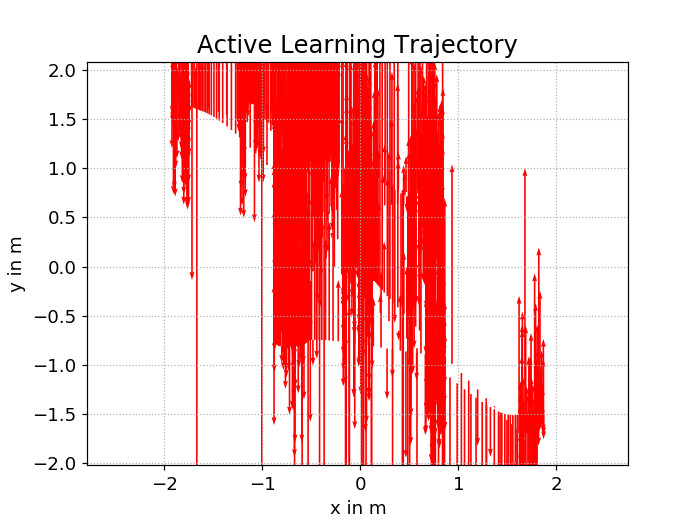

In [48]:
exp_data = pd.read_csv('/home/johanna/MasterThesis/data/exp_data_nov_04/test.csv')
training_data_array = exp_data.to_numpy()
X1 = training_data_array[:,0:2]
y1 = training_data_array[:,2:]
print(X1.shape,y1.shape)
experiment_data[1].plot_wind_field(X=X1, y=y1, res=1, title="Active Learning Trajectory", name="data2")

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent

<IPython.core.display.Javascript object>


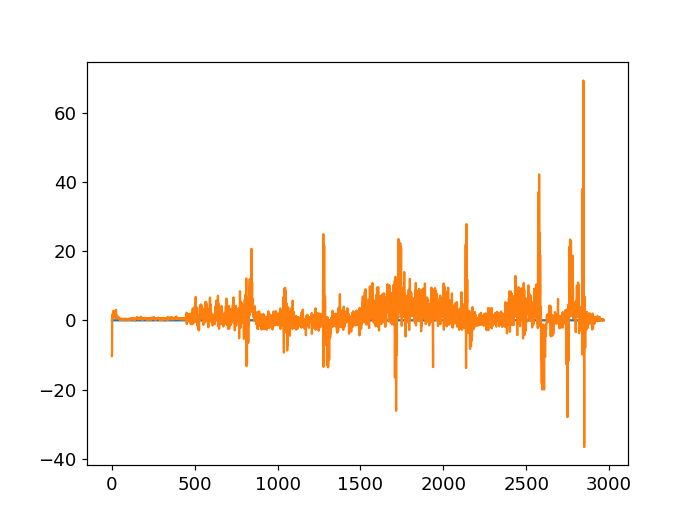

<function matplotlib.pyplot.show(*args, **kw)>

In [49]:
%matplotlib notebook
plt.plot(y1)
plt.show

In [30]:
%matplotlib notebook
vel = data1['velocity']
vel_pred = data1['velocity_pred']

plt.plot(vel[:,1])
plt.plot(vel_pred[:,1])
plt.plot(vel[:,1]-vel_pred[:,1])
plt.show()

TypeError: 'Data' object is not subscriptable

<IPython.core.display.Javascript object>


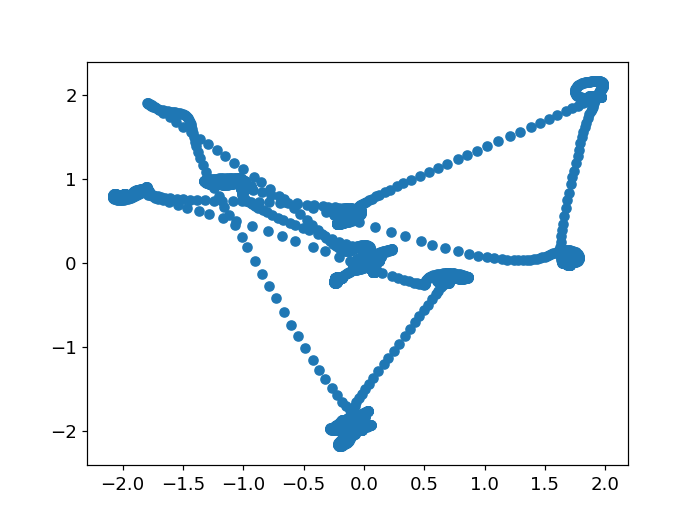

<function matplotlib.pyplot.show(*args, **kw)>

In [31]:
%matplotlib notebook
plt.scatter(X1[:,0], X1[:,1])
plt.show

In [16]:
class Data:
    def __init__(self, X=None, y=None):
        self.X = X
        self.y = y
    def set_data(self, X, y):
        self.X = X
        self.y = y
        self.read_data_torch()
    def read_data_torch(self):
        self.X_train =  torch.FloatTensor(self.X)
        self.y_train =  torch.FloatTensor(self.y)
        self.X_test =  torch.FloatTensor(self.X)
        self.y_test =  torch.FloatTensor(self.y)
    def read_data(self, inp):
        return

In [17]:
data1 = Data()
data1.set_data(X1,y1)
# data2 = Data()
# data2.set_data(X2,y2)
# data3 = Data()
# data3.set_data(X3,y3)
data4 = Data()
data4.set_data(X4,y4)
# data5 = Data()
# data5.set_data(X5,y5)


In [45]:
batch_size_list = [10,15,25]
n_epochs_list = [10,20,30,50]
for i in range(len(batch_size_list)):
    for j in range(len(n_epochs_list)):
        sparse_gp_torch = SparseGPyTorchRegression(data, batch_size_list[i], n_epochs_list[j])
        sparse_gp_torch.fit()
        sparse_gp_torch.predict(X_grid_torch)
        y_pred = sparse_gp_torch.mean
        MAE = mean_absolute_error(y_true, y_pred)
        MSE = mean_squared_error(y_true, y_pred)
        unc0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
        unc1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
        print(batch_size_list[i], n_epochs_list[j], MAE, MSE, max(unc0), np.mean(unc0), max(unc1), np.mean(unc1))

7416


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/594 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
batch_size_list = [10,20,30,40]
data_list = [data1, data2, data3, data4]
for i in range(len(batch_size_list)):
    for j in range(len(data_list)):
        sparse_gp_torch = SparseGPyTorchRegression(data_list[j], batch_size_list[i], 20)
        sparse_gp_torch.fit()
        sparse_gp_torch.predict(X_grid_torch)
        y_pred = sparse_gp_torch.mean
        MAE = mean_absolute_error(y_true, y_pred)
        MSE = mean_squared_error(y_true, y_pred)
        unc_y0 = sparse_gp_torch.lower[:,0] - sparse_gp_torch.mean[:,0]
        unc_y1 = sparse_gp_torch.lower[:,1] - sparse_gp_torch.mean[:,1]
        print(MAE, MSE)
        print(np.max(unc_y0+unc_y1), np.mean(unc_y0+unc_y1))
        data = experiment_data[-1]
        sparse_gp_torch.predict(X_grid_torch)
        data.plot_wind_field(X_grid_torch, sparse_gp_torch.mean, 4)

110


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

110


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/11 [00:00<?, ?it/s]

In [18]:
tic = time.time()
batch_size_list = [40]
data_list = [data4]
for i in range(len(batch_size_list)):
    sparse_gp_torch = SparseGPyTorchRegression(data4, batch_size_list[i], 20)
    sparse_gp_torch.fit()
    sparse_gp_torch.predict(X_grid_torch)
    sparse_gp_torch.save_model()
    y_pred = sparse_gp_torch.mean
    MAE = mean_absolute_error(y_true, y_pred)
    MSE = mean_squared_error(y_true, y_pred)
    unc_y0 = sparse_gp_torch.lower[:,0] - sparse_gp_torch.mean[:,0]
    unc_y1 = sparse_gp_torch.lower[:,1] - sparse_gp_torch.mean[:,1]
    print(MAE, MSE)
    print(np.max(unc_y0+unc_y1), np.mean(unc_y0+unc_y1))
    data = experiment_data[-1]
    sparse_gp_torch.predict(X_grid_torch)
    data.plot_wind_field(X_grid_torch, sparse_gp_torch.mean, 4)
toc = time.time() -tic
print(toc)

1129


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

/home/johanna/.local/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2115.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

1129


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

OrderedDict([('variational_strategy.inducing_points', tensor([[  0.5466,   1.7361],
        [  2.4568,  -1.6995],
        [  8.4464,  -0.1550],
        [  7.5685,   6.7030],
        [  2.1948,   9.1642],
        [ -6.4874,   9.3269],
        [ -5.8486,   1.4142],
        [ -4.8806,  -1.7437],
        [ -4.4582,  -3.1693],
        [ -8.9308,  -8.3369],
        [ -6.1267, -10.0193],
        [ -0.5081,  -9.9597],
        [  4.3458,  -9.4745],
        [  8.5289,  -9.7466],
        [  3.6850,  -5.1995],
        [ -1.6747,  -0.4793],
        [ -9.0577,  -1.8116],
        [ -9.8771,   0.3585],
        [ -9.4140,   3.3788],
        [ -8.9893,   6.6042],
        [ -2.2273,   5.3325],
        [  8.4296,   9.5419],
        [  9.6030,   3.6327],
        [  9.2675,  -3.2922],
        [  9.6410,  -5.7559],
        [  5.6534,   2.4615],
        [  2.1282,   4.6597],
        [ -8.5189,  -2.8356],
        [ -5.7213,  -4.1700],
        [ -1.8382,  -6.6605],
        [  5.9350,  -2.2478]])), ('variational

NameError: name 'y_true' is not defined

0.13686394691467285


<IPython.core.display.Javascript object>


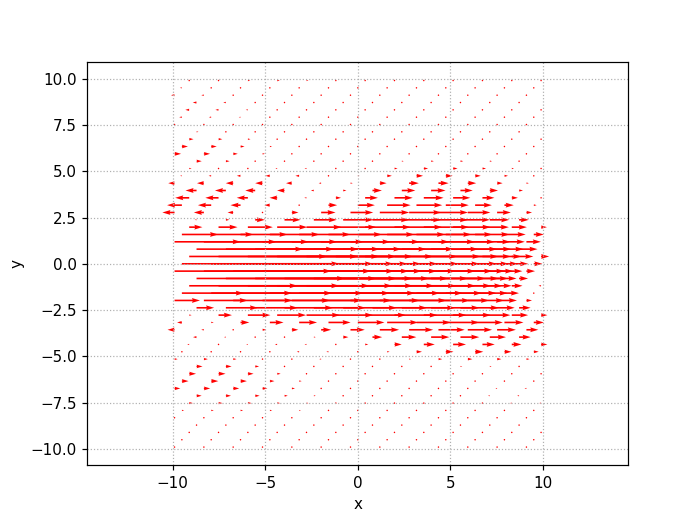

In [33]:
tic = time.time()
data = experiment_data[-1]
sparse_gp_torch.predict(X_grid_torch)
toc = time.time() -tic
print(toc)
data.plot_wind_field(X_grid_torch, sparse_gp_torch.mean, 4)



# Full GP

In [29]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [90]:
def train_GP(X_train, y_train):
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(X_train, y_train, likelihood)
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    training_iter = 50
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X_train)
        # Calc loss and backprop gradients
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()
    return model, likelihood

In [91]:
def test_GP(X_test, model, likelihood):
    model.eval()
    likelihood.eval()
    observed_pred = likelihood(model(X_test))
    mean_pred = observed_pred.mean.detach().numpy()
    lower, upper = observed_pred.confidence_region()
    lower_pred = lower.detach().numpy()
    upper_pred = upper.detach().numpy()
    
    return mean_pred, upper_pred, lower_pred

In [92]:
tic = time.time() 
model_full0, likelihood_full0 = train_GP(data4.X_train, data4.y_train[:,0])
model_full1, likelihood_full1 = train_GP(data4.X_train, data4.y_train[:,1])
toc = time.time() -tic
print(toc)

5.464151859283447


In [93]:
tic = time.time()
mean_pred0, upper_pred_0, lower_pred_0 = test_GP(X_grid_torch, model_full0, likelihood_full0)
mean_pred1, upper_pred_1, lower_pred_1 = test_GP(X_grid_torch, model_full1, likelihood_full1)
toc = time.time() -tic
print(toc)

15.701873779296875


/tmp/ipykernel_164543/2352875274.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1)


<IPython.core.display.Javascript object>


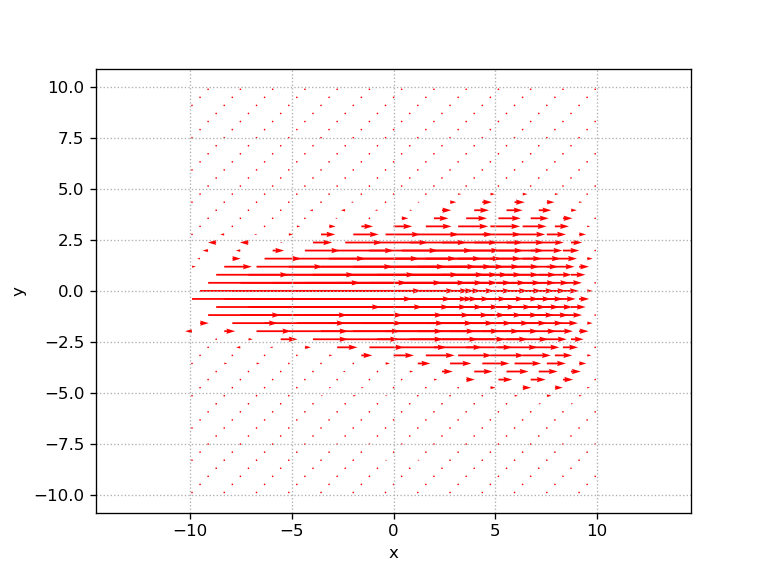

In [94]:
y_pred = np.vstack([mean_pred0, mean_pred1])
data.plot_wind_field(X_grid_torch, np.transpose(y_pred), 4)

In [95]:
unc0 = upper_pred_0 - mean_pred0
unc1 = upper_pred_1 - mean_pred1
maxunc = np.max(unc0 + unc1)
medunc = np.mean(unc0 + unc1)
print(maxunc, medunc)

1.2460476 0.4085098


In [96]:
MAE = mean_absolute_error(y_true, np.transpose(y_pred))
MSE = mean_squared_error(y_true, np.transpose(y_pred))
print(MAE, MSE)

0.0172803605322096 0.0026975455120733537


In [50]:
# Plot the uncertainties
def plot_surface(x, y, mean, upper, lower, bounds):
    mean_grid = mean.reshape(x.shape)
    fig = plt.figure()
    if bounds:
        upper_grid = upper.reshape(x.shape)
        lower_grid = lower.reshape(x.shape)
        ax = fig.gca(projection='3d')
        ax.plot_surface(x, y, mean_grid,  color='C0', alpha=0.8)
        ax.plot_surface(x, y, upper_grid, cmap=cm.coolwarm, alpha=0.5)
        ax.plot_surface(x, y, lower_grid, cmap=cm.coolwarm, alpha=0.5)
    else:
        ax1 = fig.subplots(1, 1)
        ax1 = plt.contourf(x, y, mean_grid)
        plt.colorbar(ax1)
    plt.ioff()
    plt.show()

In [52]:
%matplotlib notebook
plot_surface(x_grid, y_grid, sparse_gp_torch.mean[:,1], sparse_gp_torch.upper[:,1], sparse_gp_torch.lower[:,1], True)
plot_surface(x_grid, y_grid, sparse_gp_torch.mean[:,0], sparse_gp_torch.upper[:,0], sparse_gp_torch.lower[:,0], True)

AttributeError: 'SparseGPyTorchRegression' object has no attribute 'mean'

In [60]:
def compute_coordinate_distance(a, b):
    return ((a[0]-b[0])**2+(a[1]-b[1])**2)**0.5

<IPython.core.display.Javascript object>


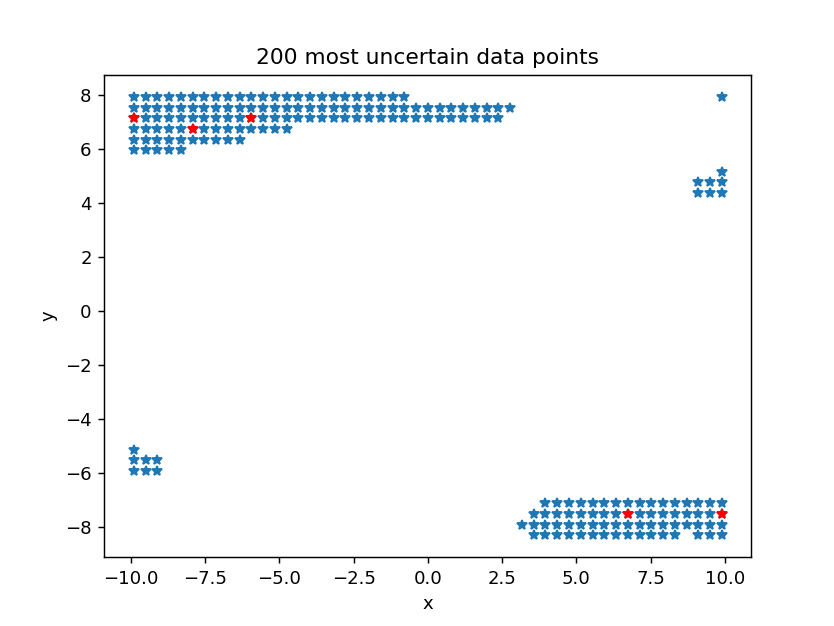

In [64]:
unc0 = sparse_gp_torch.lower[:,0] - sparse_gp_torch.mean[:,0]
unc1 = sparse_gp_torch.lower[:,1] - sparse_gp_torch.mean[:,1]
idx = np.argsort(unc0 + unc1)[-200:]
X_samp1 = X_grid[idx]
radius = 2
unc_y0 = sparse_gp_torch.lower[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.lower[:,1] - sparse_gp_torch.mean[:,1]
idx_0 = np.argsort(unc_y0 + unc_y1)[-1]
X_path = []
X_path.append(X_grid[idx_0])
i = 1
while (len(X_path) < 5):
    idx = np.argsort(unc_y0 + unc_y1)[-i]
    X_samp = X_grid[idx]
    dist_array = []
    for j in range(len(X_path)):
        dist = compute_coordinate_distance(X_samp, X_path[j])
        dist_array.append(dist)
    if not any(k < radius for k in dist_array):
        X_path.append(X_samp)
    i = i+1
X_path = np.reshape(X_path, (-1,2))
plt.plot(X_samp1[:,0],X_samp1[:,1], '*')
plt.plot(X_path[:,0],X_path[:,1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('200 most uncertain data points')
plt.show()

## X_path

In [203]:
y_true = mean_gt[:,0:2]
y_pred = sparse_gp_torch.mean
MAE = mean_absolute_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
print(MAE, MSE)

0.39264061234529546 0.529376798922504


# Investigate training parameters

In [160]:
batch_size_list = [5,10,15,20,25,30]
n_epochs_list = [5,10,20,30,40,50]
for i in range(len(batch_size_list)):
    for j in range(len(n_epochs_list)):
        sparse_gp_torch = SparseGPyTorchRegression(data, batch_size_list[i], n_epochs_list[j])
        sparse_gp_torch.fit()
        sparse_gp_torch.predict(X_grid_torch)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/711 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Evaluation

In [14]:
df = pd.DataFrame(data.kernel_dict.values(), columns=["l1", "l2", "sigma_f", "variance", "sigma_n"])
df.insert(0, "Training_algorithm", data.kernel_dict.keys())
df

,Training_algorithm,l1,l2,sigma_f,variance,sigma_n


In [15]:
data.prediction_dict.keys()
np.savez('data_prediction', **data.prediction_dict)
np.savez('kernel', **data.kernel_dict)

In [16]:
data.prediction_dict['gpytorch_10_2'][0]

KeyError: 'gpytorch_10_2'

In [17]:
def create_grid(start, stop, res, array_type = None):
    x = np.linspace(start, stop, res)
    y = np.linspace(start, stop, res)
    x, y = np.meshgrid(x, y)
    if array_type is None:
        X = np.stack((x.flatten(), y.flatten()), axis=-1)
    else:
        X = torch.FloatTensor(np.stack((x.flatten(), y.flatten()), axis=-1))
    return X, x, y
X_grid, x_grid, y_grid = create_grid(-10,9.9,51)
X_grid_torch, x_grid_torch, y_grid_torch = create_grid(-10,9.9,51, "torch")

In [18]:
sparse_gp_torch.predict(X_grid_torch)
data.plot_wind_field(X_grid_torch, sparse_gp_torch.mean, 4)

IndexError: list index out of range

# Query the 10 most uncertain points

In [110]:
unc0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]

In [111]:
X_grid.size

5202

In [112]:
idx = np.argsort(unc0 + unc1)[0:100]
X_samp = X_grid[idx]
idx

array([2561, 2560, 2562, 2559, 1437, 1386, 1387, 1438, 2563, 2558, 1488,
       1436, 1385, 1335, 1487, 1336, 1489, 1388, 1334, 1439, 1539, 1538,
       1337, 2564, 1435, 1284, 2557, 1384, 1486, 1285, 1490, 1540, 1589,
       1283, 1537, 1333, 1389, 1590, 1440, 1286, 1588, 1338, 2509, 2510,
       2508, 1640, 1282, 2511, 1639, 1541, 1233, 1491, 2565, 1591, 2507,
       1232, 1234, 1434, 1641, 1287, 1383, 2556, 1485, 2512, 1390, 1690,
       1536, 1332, 1691, 1587, 1339, 1441, 1235, 1231, 1638, 2506, 1281,
       1741, 1689, 2513, 1542, 1592, 1692, 1642, 1742, 1288, 1492, 1740,
       1236, 1182, 1181, 1230, 1792, 2566, 1391, 1183, 1180, 2010, 2576,
       2505])

<IPython.core.display.Javascript object>


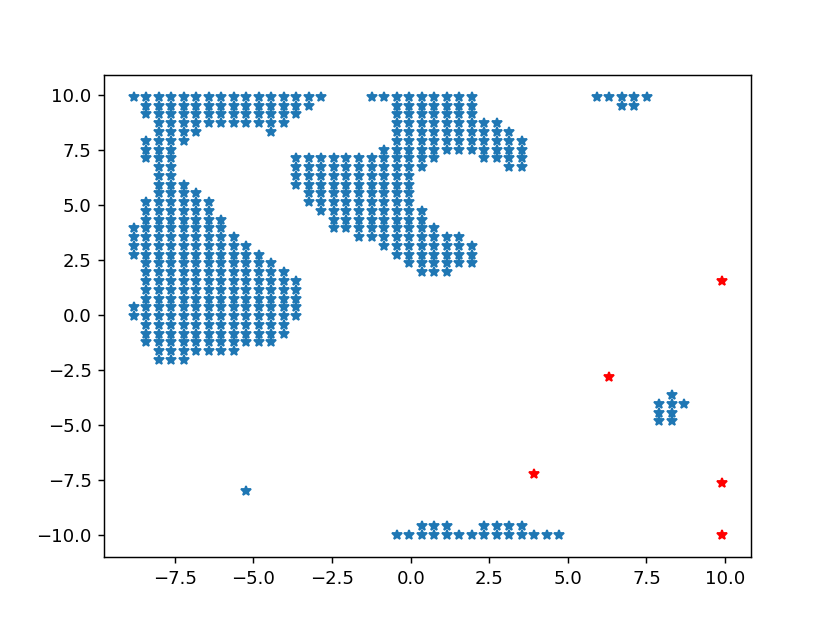

In [116]:
plt.plot(X_samp[:,0],X_samp[:,1], '*')
plt.plot(X_path[:,0],X_path[:,1], 'r*')
plt.show()

In [114]:
idx = np.argsort(unc0 + unc1)[0:10]
X_samp = X_grid[idx]
X_samp

array([[-5.622,  9.9  ],
       [-6.02 ,  9.9  ],
       [-5.224,  9.9  ],
       [-6.418,  9.9  ],
       [-6.418,  1.144],
       [-6.418,  0.746],
       [-6.02 ,  0.746],
       [-6.02 ,  1.144],
       [-4.826,  9.9  ],
       [-6.816,  9.9  ]])

In [115]:
from sklearn.cluster import KMeans
idx = np.argsort(unc0 + unc1)[0:500]
X_samp = X_grid[idx]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_samp)
centers = kmeans.cluster_centers_

In [61]:
def compute_coordinate_distance(a, b):
    return ((a[0]-b[0])**2+(a[1]-b[1])**2)**0.5

In [62]:
radius = 2
unc_y0 = sparse_gp_torch.upper[:,0] - sparse_gp_torch.mean[:,0]
unc_y1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
idx_0 = np.argsort(unc_y0 + unc_y1)[0]
X_path = []
X_path.append(X_grid[idx_0])
i = 1
while (len(X_path) < 5):
    idx = np.argsort(unc_y0 + unc_y1)[i]
    X_samp = X_grid[idx]
    dist_array = []
    for j in range(len(X_path)):
        dist = compute_coordinate_distance(X_samp, X_path[j])
        dist_array.append(dist)
    print(dist_array)
    if not any(k < radius for k in dist_array):
        X_path.append(X_samp)
    print(X_path)
    i = i+1

[0.3979999999999997]
[array([ 3.93 , -7.214])]
[6.588072252184248]
[array([ 3.93 , -7.214]), array([  9.9, -10. ])]
[0.5628569978244926, 6.062155392267672]
[array([ 3.93 , -7.214]), array([  9.9, -10. ])]
[0.39800000000000146, 6.229685385314415]
[array([ 3.93 , -7.214]), array([  9.9, -10. ])]
[6.429886779718601, 0.3979999999999997]
[array([ 3.93 , -7.214]), array([  9.9, -10. ])]
[0.3979999999999997, 6.766000000000002]
[array([ 3.93 , -7.214]), array([  9.9, -10. ])]
[0.3979999999999997, 6.950771180236048]
[array([ 3.93 , -7.214]), array([  9.9, -10. ])]
[6.292932543735078, 0.7959999999999994]
[array([ 3.93 , -7.214]), array([  9.9, -10. ])]
[0.7959999999999994, 6.292932543735078]
[array([ 3.93 , -7.214]), array([  9.9, -10. ])]
[0.5628569978244914, 6.801026981272757]
[array([ 3.93 , -7.214]), array([  9.9, -10. ])]
[0.8899550550449163, 5.916695361432766]
[array([ 3.93 , -7.214]), array([  9.9, -10. ])]
[6.178621529111492, 1.193999999999999]
[array([ 3.93 , -7.214]), array([  9.9, -10

<IPython.core.display.Javascript object>


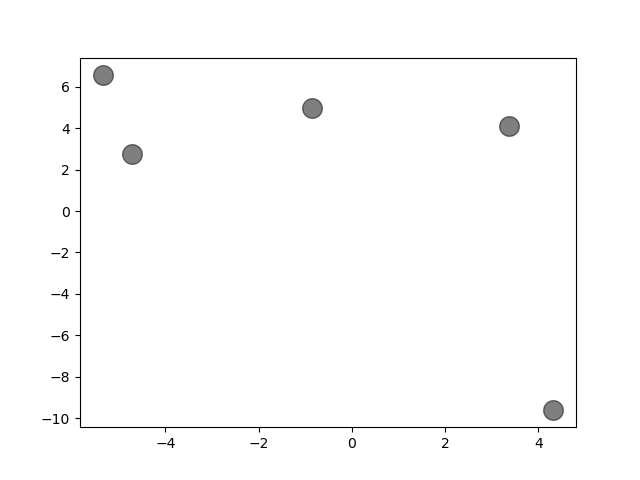

In [184]:
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()

## Compare to Ground Thruth

<IPython.core.display.Javascript object>


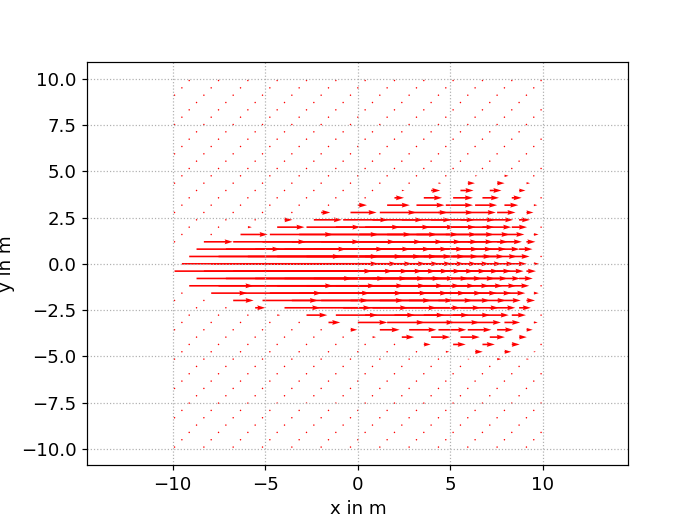

In [39]:
class WindCalculator:
    def __init__(self,windfield_params):
        self.windfield_params = windfield_params
        self.windfield_params = windfield_params
        self.use_custom_windfield = self.windfield_params['use_custom_windfield']
        self.wind_direction = self.windfield_params['wind_direction']
        self.wind_velocity = self.windfield_params['wind_velocity']
        wind_norm = np.sqrt(self.wind_direction[0] ** 2 + self.wind_direction[1] ** 2 + self.wind_direction[2] ** 2)
        self.wind_direction = self.wind_direction / wind_norm
        if self.use_custom_windfield:
            windfield_path= self.windfield_params['windfield_path']
            try:
                f = open(windfield_path)
            except:
                print("File '" + windfield_path + "' does not exist!")
                exit(1)

            name = ""
            data = dict()
            for i in range(26):
                val = f.readline()
                if i % 2 == 0:
                    val = str(val)
                    val = val.replace(" ", "")
                    val = val.replace("\n", "")
                    val = val.replace(":", "")
                    name = val
                else:
                    line = np.fromstring(str(val), sep=" ")
                    if (len(line) == 1):
                        line = line[0]
                    data[name] = line

            self.min_x_ = data["min_x"]
            self.min_y_ = data["min_y"]
            self.n_x_ = int(data["n_x"])
            self.n_y_ = int(data["n_y"])
            self.res_x_ = data["res_x"]
            self.res_y_ = data["res_y"]
            self.vertical_spacing_factors_ = data["vertical_spacing_factors"]
            self.bottom_z_ = data["bottom_z"]
            self.top_z_ = data["top_z"]
            self.u_vec_ = data["u"]
            self.v_vec_ = data["v"]
            self.w_vec_ = data["w"]

            self.n_z = len(self.vertical_spacing_factors_)

    def linear_interpolation(self, position, values, points):
        value = values[0] + (values[1] - values[0]) / (points[1] - points[0]) * (position - points[0])
        return value

    def bilinear_interpolation(self, position, values, points):
        intermediate_values = np.array([self.linear_interpolation(position[0], values[0:], points[0:]),
                                        self.linear_interpolation(position[0], values[2:], points[2:])])
        value = self.linear_interpolation(position[1], intermediate_values, points[4:])
        return value

    def trilinear_interpolation(self, position, values, points):
        intermediate_values = np.array([self.linear_interpolation(position[2], values[0:], points[0:]),
                                        self.linear_interpolation(position[2], values[2:], points[2:]),
                                        self.linear_interpolation(position[2], values[4:], points[4:]),
                                        self.linear_interpolation(position[2], values[6:], points[6:])])
        value = self.bilinear_interpolation(position[0:],intermediate_values, points[8:])
        return value

    def calculate_windfield(self, link_position):

        if self.use_custom_windfield:
            # Calculate x,y index just smaller than aircraft position or equal to
            x_inf = math.floor((link_position[0] - self.min_x_) / self.res_x_)
            y_inf = math.floor((link_position[1] - self.min_y_) / self.res_y_)

            # In case aircraft is on one of the boundary surfaces at max_x or max_y,
            # decrease x_inf, y_inf by one to have x_sup, y_sup on max_x, max_y.
            if x_inf == self.n_x_ - 1:
                x_inf = self.n_x_ - 2
            if y_inf == self.n_y_ - 1:
                y_inf = self.n_y_ - 2

            # Calculate x,y index just larger than aircraft position
            x_sup = x_inf + 1
            y_sup = y_inf + 1

            # Save grid points enclosing the aircraft in an array
            n_vertices = 8
            idx_x = np.array([x_inf, x_inf, x_sup, x_sup, x_inf, x_inf, x_sup, x_sup])
            idx_y = np.array([y_inf, y_inf, y_inf, y_inf, y_sup, y_sup, y_sup, y_sup])

            # Find vertical factors in each of the four surrounding
            # grid columns, and their minimal/maximal value.
            n_columns = 4
            vertical_factors_columns = np.empty(n_columns)
            for i in range(n_columns):
                vertical_factors_columns[i] = (link_position[2] - self.bottom_z_[
                    idx_x[2 * i] + idx_y[2 * i] * self.n_x_]) \
                                              / (self.top_z_[idx_x[2 * i] + idx_y[2 * i] * self.n_x_] -
                                                 self.bottom_z_[idx_x[2 * i] + idx_y[2 * i] * self.n_x_])

            # Find minimal and maximal vertical factor
            vertical_factors_min = min(min(min(
                vertical_factors_columns[0], vertical_factors_columns[1]),
                vertical_factors_columns[2]), vertical_factors_columns[3])
            vertical_factors_max = max(max(max(
                vertical_factors_columns[0], vertical_factors_columns[1]),
                vertical_factors_columns[2]), vertical_factors_columns[3])

            # Check if aircraft is out of wind field or not, and act accordingly.
            if (x_inf >= 0 and y_inf >= 0 and vertical_factors_max >= 0 and
                    x_sup <= (self.n_x_ - 1) and y_sup <= (self.n_y_ - 1) and vertical_factors_min <= 1):
                # Find indices in z-direction for each of the vertices.If link is not
                # within the range of one of the columns, set to lowest or highest two.
                idx_z = [0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1]
                for i in range(n_columns):
                    if vertical_factors_columns[i] < 0:
                        # Link z - position below lowest grid point of that column
                        idx_z[2 * i + 1] = 1
                    elif vertical_factors_columns[i] >= 1:
                        # Link z-position above highest grid point of that column
                        idx_z[2 * i] = len(self.vertical_spacing_factors_) - 2
                    else:
                        # Link z-position between two grid points in that column.
                        for j in range(len(vertical_factors_columns) - 1):
                            if self.vertical_spacing_factors_[j] <= vertical_factors_columns[i] < \
                                    self.vertical_spacing_factors_[j + 1]:
                                idx_z[2 * i] = j
                                idx_z[2 * i + 1] = j + 1
                                break

                # Extract the wind velocities corresponding to each vertex
                wind_at_vertices = np.empty([8, 3])
                for i in range(n_vertices):
                    wind_at_vertices[i, 0] = self.u_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]
                    wind_at_vertices[i, 1] = self.v_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]
                    wind_at_vertices[i, 2] = self.w_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]

                # Extract the relevant coordinate of every point needed for trilinear interpolation
                n_points_interp_z = 8
                n_points_interp_x = 4
                n_points_interp_y = 2
                interpolation_points = np.empty(n_points_interp_x + n_points_interp_y + n_points_interp_z)
                for i in range(n_points_interp_x + n_points_interp_y + n_points_interp_z):
                    if i < n_points_interp_z:
                        interpolation_points[i] = (self.top_z_[idx_x[i] + idx_y[i] * self.n_x_] - self.bottom_z_[
                            idx_x[i] + idx_y[i] * self.n_x_]) \
                                                  * self.vertical_spacing_factors_[idx_z[i]] + self.bottom_z_[
                                                      idx_x[i] + idx_y[i] * self.n_x_]
                    elif n_points_interp_z <= i < n_points_interp_x + n_points_interp_z:
                        interpolation_points[i] = self.min_x_ + self.res_x_ * idx_x[2 * (i - n_points_interp_z)]
                    else:
                        interpolation_points[i] = self.min_y_ + self.res_y_ * idx_y[
                            4 * (i - n_points_interp_z - n_points_interp_x)]

                wind_v = self.trilinear_interpolation(link_position, wind_at_vertices, interpolation_points)
            else:
                print("Drone is outside of specified custom windfield, using default one")
                wind_v = self.wind_direction * self.wind_velocity
        else:
            wind_v = self.wind_direction * self.wind_velocity
        return wind_v

    def return_ground_truth(self):
        mean = []
        x = self.windfield_params['x'].flatten()
        y = self.windfield_params['y'].flatten()
        for i in range(x.size):
            link_position = [x[i], y[i], 2] #Random z parameter for now
            wind_v = self.calculate_windfield(link_position)
            mean.append(wind_v)
        mean = np.array(mean)
        return mean
wind_field_parameters = {'use_custom_windfield': True, 'wind_direction': np.array([1.0, 1.0, 0.0]), 'wind_velocity': 1.0, 'x':x_grid, 'y':y_grid, 'windfield_path':'/home/johanna/uav_mpcc/src/model_sim/include/custom_wind_fields/fan_x_dir_strength_5.txt'}
wind_calculator = WindCalculator(wind_field_parameters)
mean_gt = wind_calculator.return_ground_truth()
y_true = mean_gt[:,0:2]
data.plot_wind_field(X_grid, mean_gt, 4, None, "windfield_random")

# Evaluation of the training parameters

In [119]:
# data.prediction_dict)
# data.kernel_dict)
evaluation_dict = {}
MSE_list = []
MAE_list = []
max_unc0_list = []
max_unc1_list = []
mean_unc0_list = []
mean_unc1_list = []
for key in data.prediction_dict:
    print(key)
    y_true = mean_gt[:,0:2]
    y_pred = data.prediction_dict[key][0]
    MAE = mean_absolute_error(y_true, y_pred)
    MAE_list.append(MAE)
    MSE = mean_squared_error(y_true, y_pred)
    MSE_list.append(MSE)
    evaluation_dict[key] = [MAE, MSE]
    unc0 = data.prediction_dict[key][2][:,0] - data.prediction_dict[key][0][:,0]
    unc1 = data.prediction_dict[key][2][:,1] - data.prediction_dict[key][0][:,1]
    max_unc0 = np.max(unc0)
    max_unc1 = np.max(unc1)
    mean_unc0 = np.mean(unc0)
    mean_unc1 = np.mean(unc1)
    max_unc0_list.append(max_unc0)
    max_unc1_list.append(max_unc1)
    mean_unc0_list.append(mean_unc0)
    mean_unc1_list.append(mean_unc1)

gpytorch_30_10


In [122]:
MAE_list
MSE_list

[0.04854844988278507]

<IPython.core.display.Javascript object>


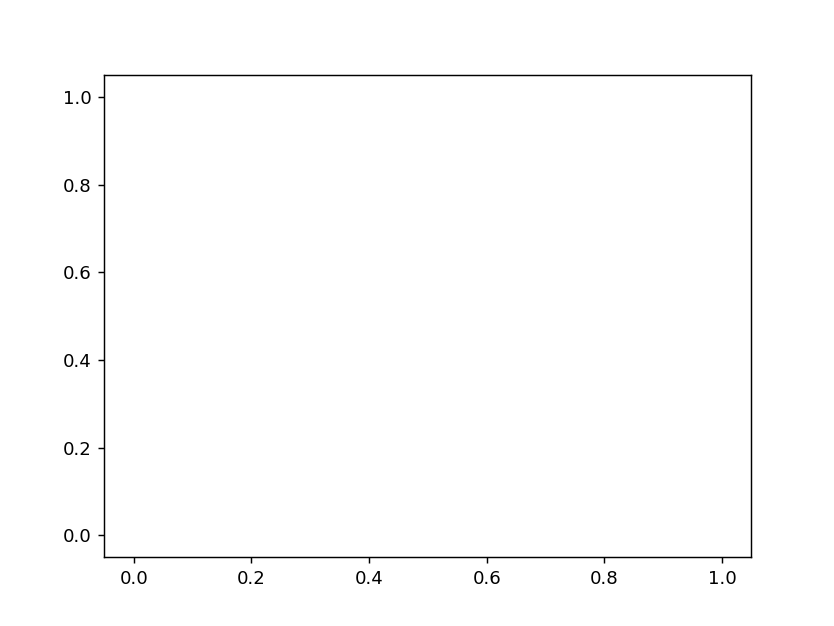

In [120]:
plt.plot(MAE_list[7:12])
plt.show()

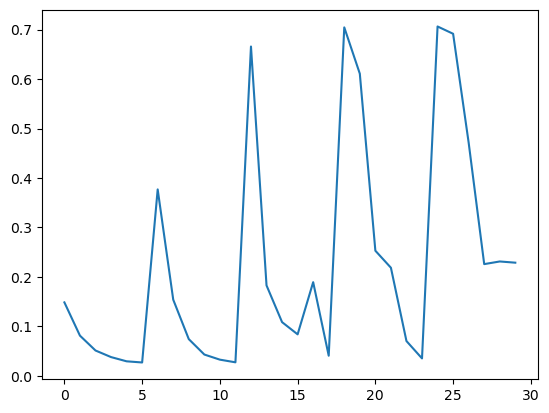

In [59]:
plt.plot(MSE_list)
plt.show()

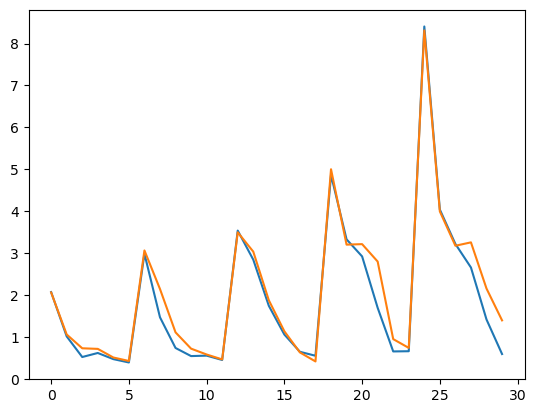

In [60]:
plt.plot(max_unc0_list)
plt.plot(max_unc1_list)
plt.show()

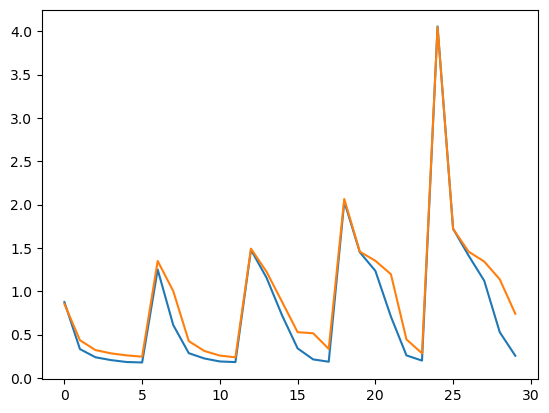

In [61]:
plt.plot(mean_unc0_list)
plt.plot(mean_unc1_list)
plt.show()

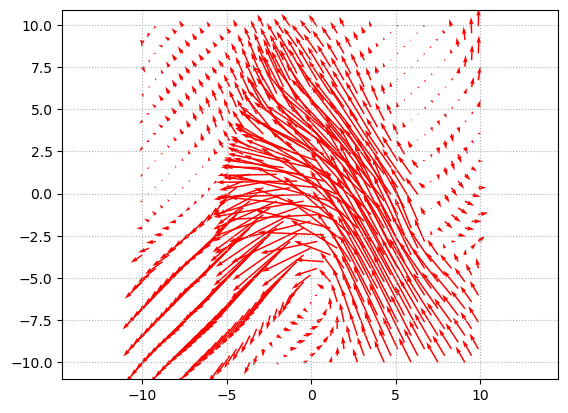

In [78]:
data.plot_wind_field(X_grid_torch, data.prediction_dict['gpytorch_50_10'][0], 4)